<a href="https://colab.research.google.com/github/jainatshu/Optimization_OF_Advance_manufacturing_Process/blob/main/Composites_ML_Intern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
df = pd.read_csv('naya.csv')

In [ ]:
df.shape

(18000, 11)

In [ ]:
df.columns

Index(['serial no.', 'matrix-to-filler ratio', 'Density', 'elastic modulus',
       'Amount of hardener', 'Epoxy group content', 'Flash point',
       'Surface density', 'Tensile modulus', 'Tensile strength',
       'Resin consumption'],
      dtype='object')

In [ ]:
df = df.drop(columns=['serial no.'])

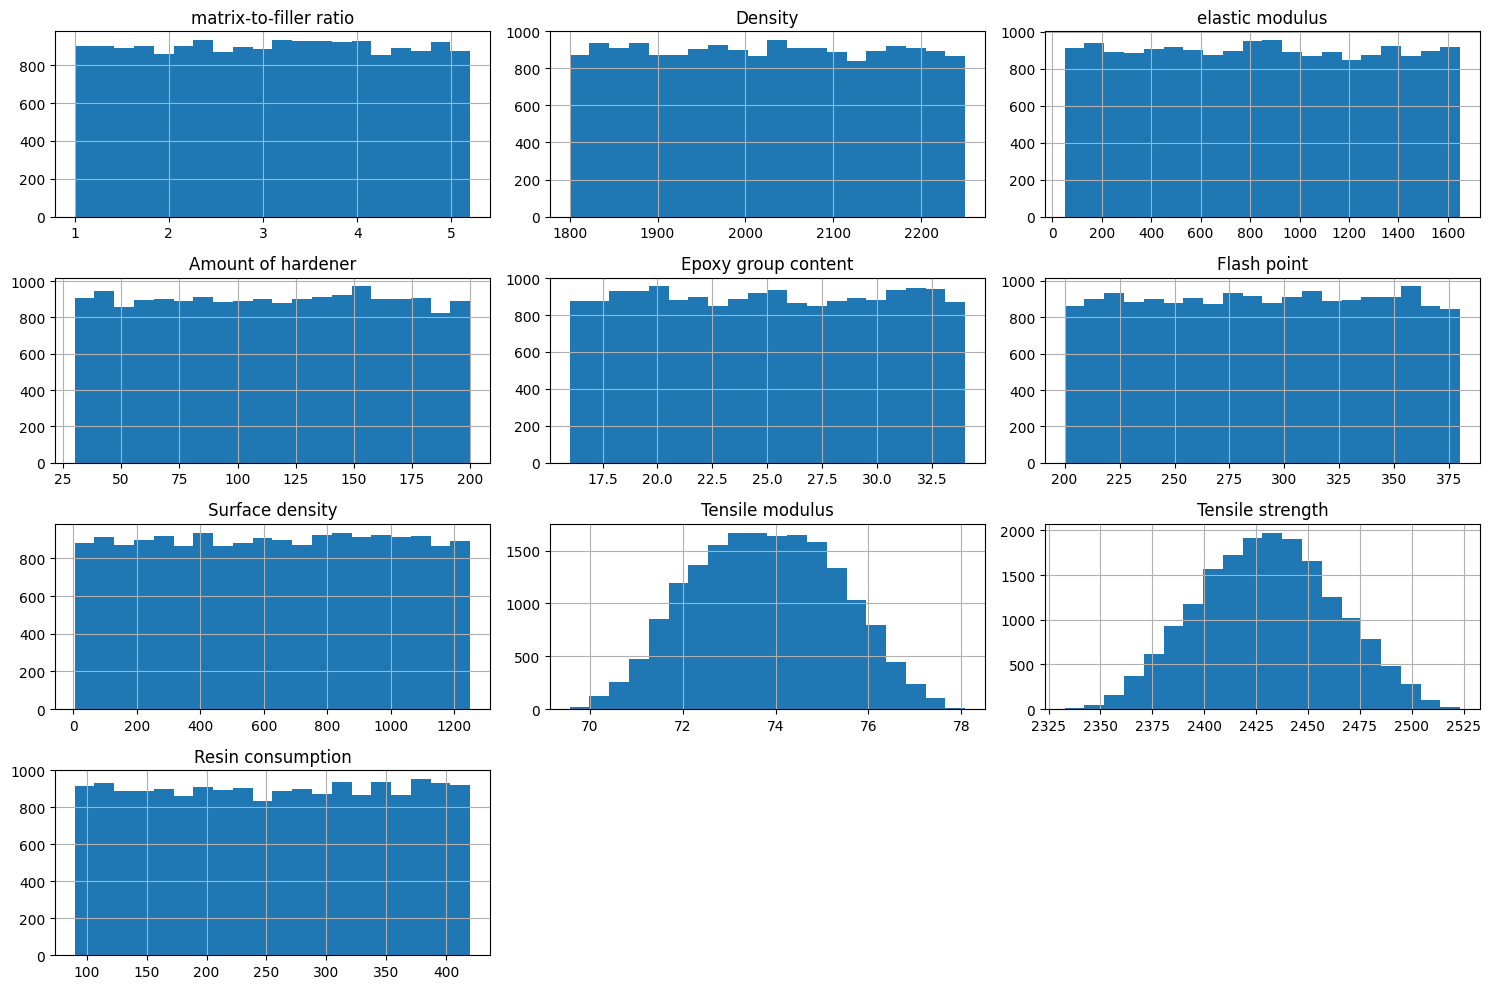

In [ ]:
df.hist(figsize=(15, 10), bins=20)
plt.tight_layout()
plt.show()

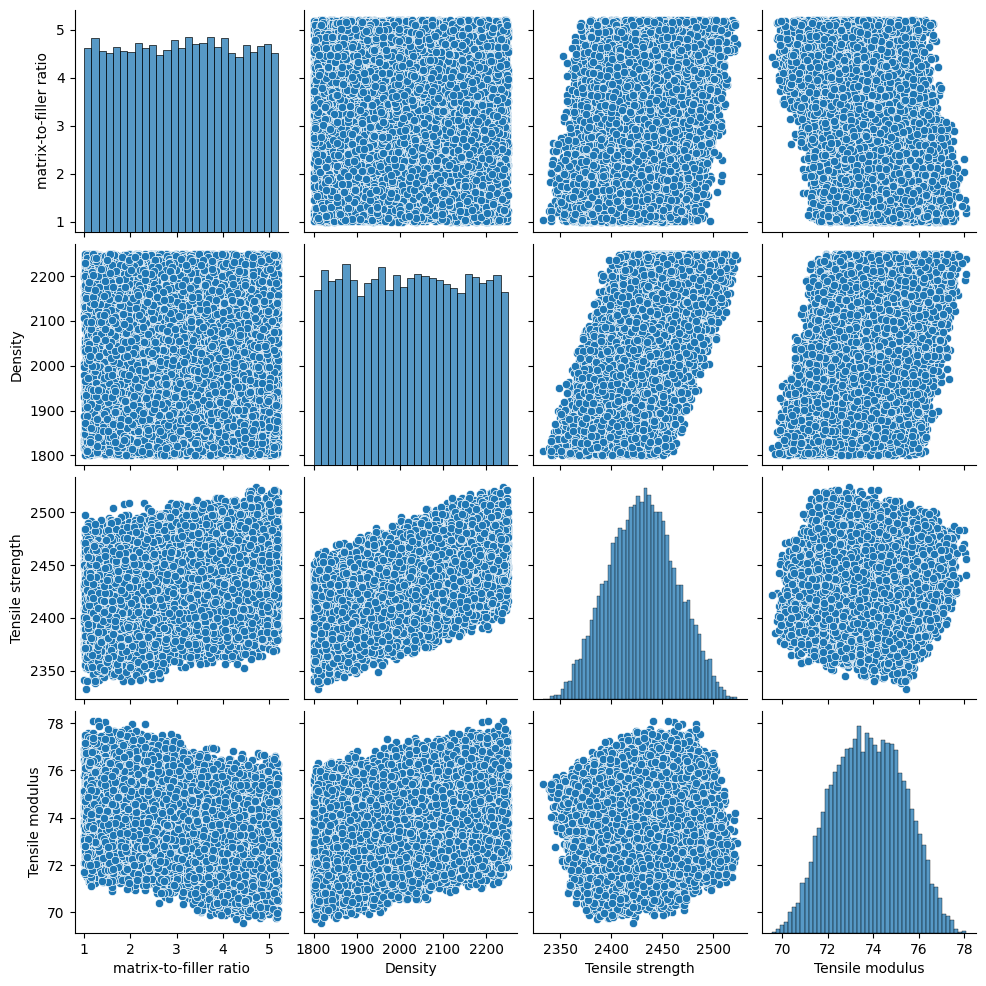

In [ ]:
sns.pairplot(df[['matrix-to-filler ratio', 'Density', 'Tensile strength', 'Tensile modulus']])
plt.show()

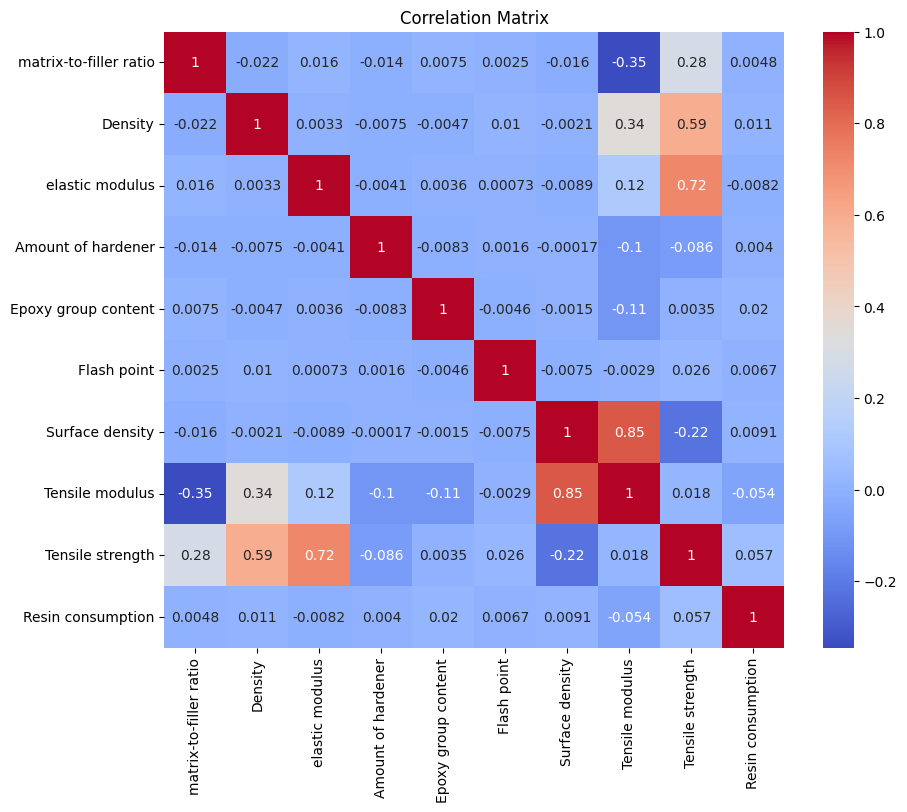

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define input and output columns
input_cols = ['matrix-to-filler ratio', 'Density', 'elastic modulus',
              'Amount of hardener', 'Epoxy group content', 'Flash point',
              'Surface density', 'Resin consumption']

output_cols = ['Tensile modulus', 'Tensile strength']

# Feature matrix and target matrix
X = df[input_cols]
y = df[output_cols]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

xgb_models = {}
xgb_preds = {}
xgb_metrics = {}

# Train one model per output
for target in output_cols:
    model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
    model.fit(X_train_scaled, y_train[target])
    preds = model.predict(X_test_scaled)

    xgb_models[target] = model
    xgb_preds[target] = preds
    xgb_metrics[target] = {
        "MAE": mean_absolute_error(y_test[target], preds),
        "R2": r2_score(y_test[target], preds)
    }

xgb_metrics

{'Tensile modulus': {'MAE': 0.06937242546329743, 'R2': 0.9968841186244053},
 'Tensile strength': {'MAE': 1.5702492100694443, 'R2': 0.9965120455352459}}

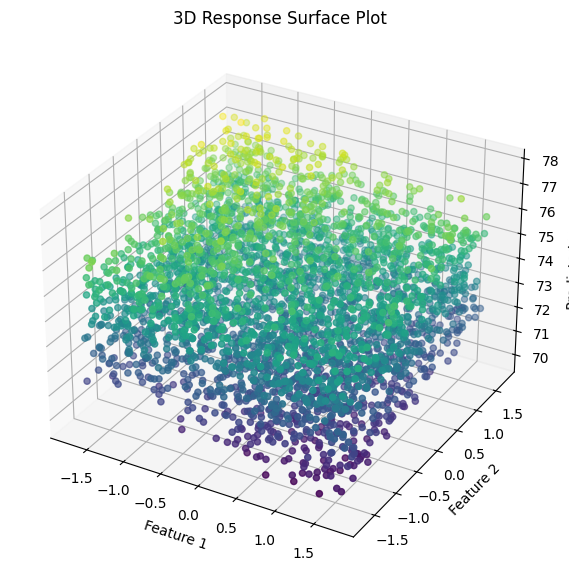

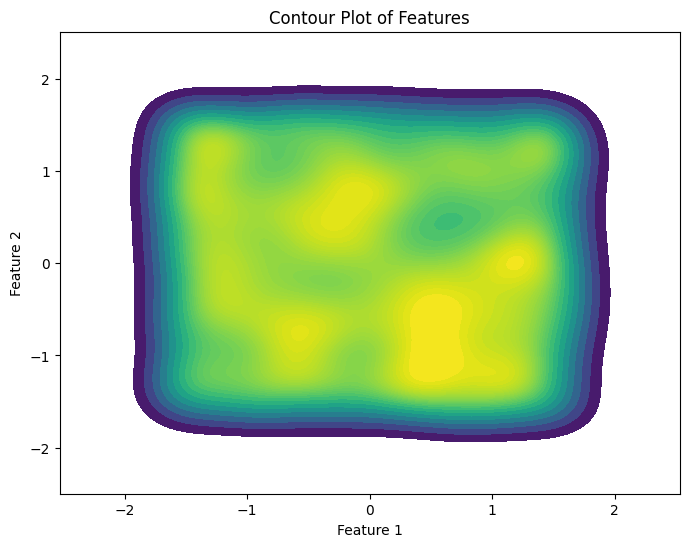

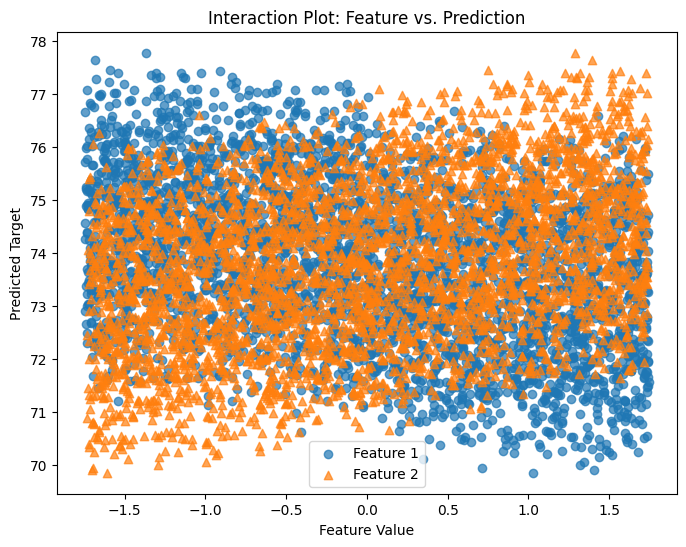

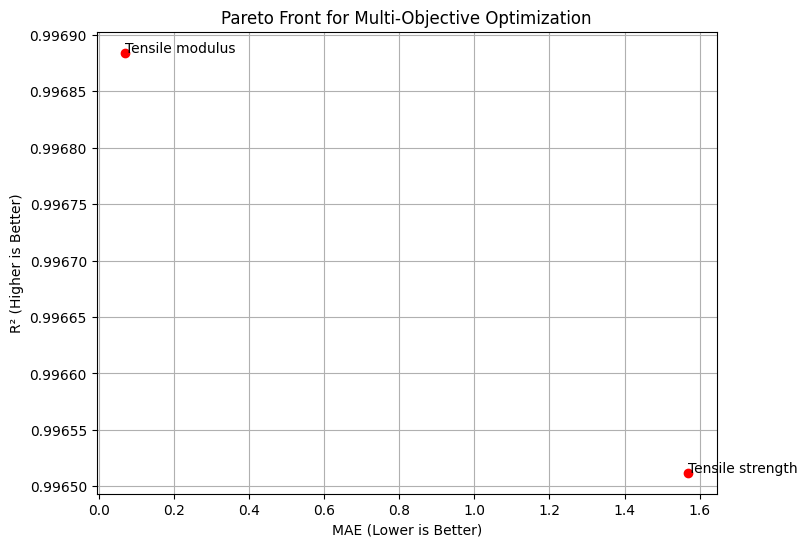

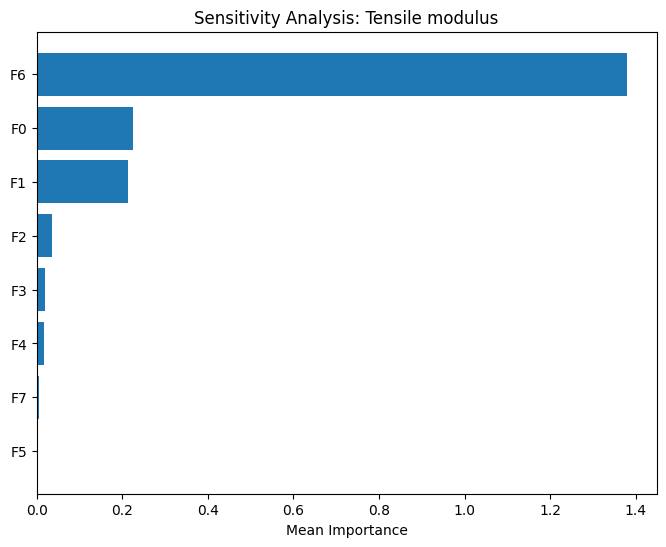

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.inspection import permutation_importance

# Select first two features for plotting purposes
feature1 = X_test_scaled[:, 0]
feature2 = X_test_scaled[:, 1]

# Plot for the first target only for simplicity
target = output_cols[0]
preds = xgb_preds[target]

# 1. 3D Response Surface Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feature1, feature2, preds, c=preds, cmap='viridis')
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Predicted Value")
ax.set_title("3D Response Surface Plot")
plt.show()

# 2. Contour Plot
plt.figure(figsize=(8, 6))
sns.kdeplot(x=feature1, y=feature2, fill=True, cmap="viridis", levels=30)
plt.title("Contour Plot of Features")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# 3. Interaction Plot (Feature vs. Prediction)
plt.figure(figsize=(8, 6))
plt.scatter(feature1, preds, alpha=0.7, label='Feature 1')
plt.scatter(feature2, preds, alpha=0.7, label='Feature 2', marker='^')
plt.title("Interaction Plot: Feature vs. Prediction")
plt.xlabel("Feature Value")
plt.ylabel("Predicted Target")
plt.legend()
plt.show()

# 4. Pareto Front Plot (MAE vs R2 for each target)
mae_vals = [xgb_metrics[t]["MAE"] for t in output_cols]
r2_vals = [xgb_metrics[t]["R2"] for t in output_cols]

plt.figure(figsize=(8, 6))
plt.scatter(mae_vals, r2_vals, c='red')
for i, t in enumerate(output_cols):
    plt.annotate(t, (mae_vals[i], r2_vals[i]))
plt.xlabel("MAE (Lower is Better)")
plt.ylabel("R² (Higher is Better)")
plt.title("Pareto Front for Multi-Objective Optimization")
plt.grid(True)
plt.show()

# 5. Sensitivity Analysis (Permutation Importance for first model)
model = xgb_models[target]
result = permutation_importance(model, X_test_scaled, y_test[target], n_repeats=10, random_state=42, n_jobs=-1)

importances = result.importances_mean
sorted_idx = np.argsort(importances)

plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [f"F{i}" for i in sorted_idx])
plt.xlabel("Mean Importance")
plt.title(f"Sensitivity Analysis: {target}")
plt.show()

KNN

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
# Load dataset
df = pd.read_csv('naya.csv')
# Define input features and target variables
X = df[['matrix-to-filler ratio', 'Density', 'elastic modulus',
        'Amount of hardener', 'Epoxy group content', 'Flash point',
        'Surface density', 'Resin consumption']]
y_modulus = df['Tensile modulus']
y_strength = df['Tensile strength']
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Split into train and test sets
X_train, X_test, y_modulus_train, y_modulus_test, y_strength_train, y_strength_test = train_test_split(
    X_scaled, y_modulus, y_strength, test_size=0.2, random_state=42)
#alize KNN regressors# Initi
knn_modulus = KNeighborsRegressor(n_neighbors=5)
knn_strength = KNeighborsRegressor(n_neighbors=5)

# Train models
knn_modulus.fit(X_train, y_modulus_train)
knn_strength.fit(X_train, y_strength_train)

# Predict on test data
y_modulus_pred = knn_modulus.predict(X_test)
y_strength_pred = knn_strength.predict(X_test)

# Evaluate performance
mae_modulus = mean_absolute_error(y_modulus_test, y_modulus_pred)
r2_modulus = r2_score(y_modulus_test, y_modulus_pred)

mae_strength = mean_absolute_error(y_strength_test, y_strength_pred)
r2_strength = r2_score(y_strength_test, y_strength_pred)
# Print results
print("Tensile Modulus:")
print(f"MAE: {mae_modulus:.3f}")
print(f"R²: {r2_modulus:.3f}\n")

print("Tensile Strength:")
print(f"MAE: {mae_strength:.3f}")
print(f"R²: {r2_strength:.3f}")

Tensile Modulus:
MAE: 0.252
R²: 0.959

Tensile Strength:
MAE: 5.302
R²: 0.959


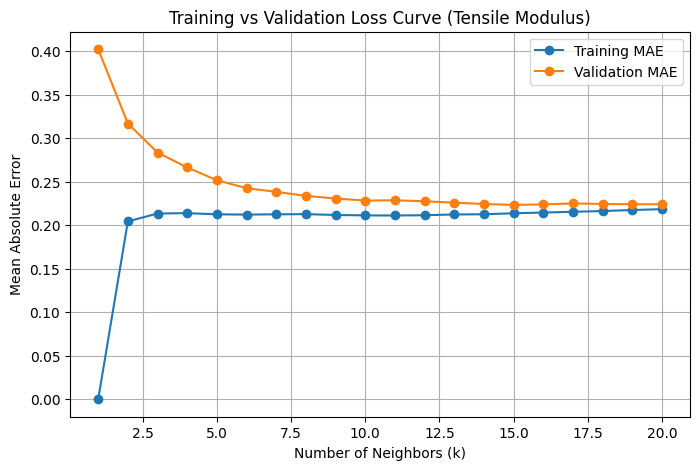

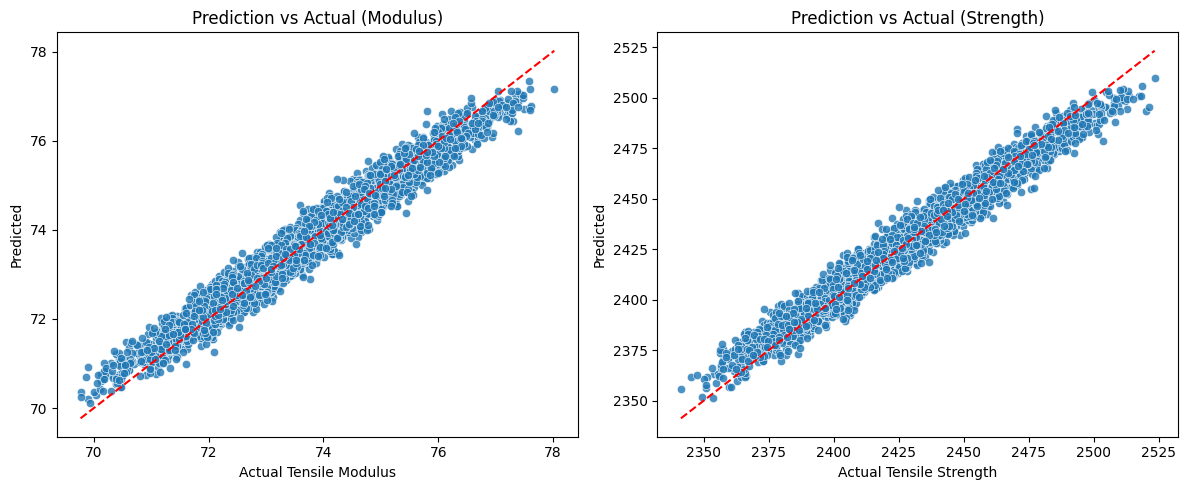

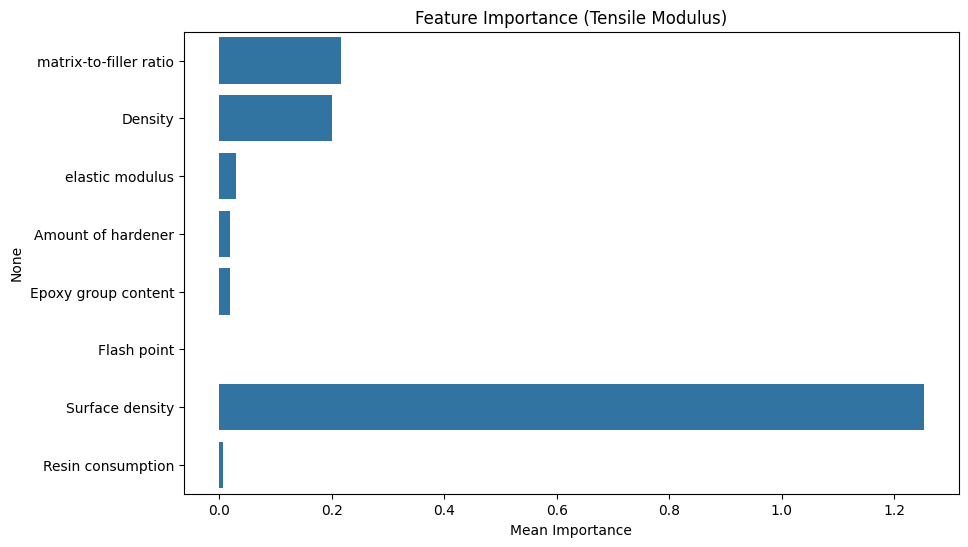

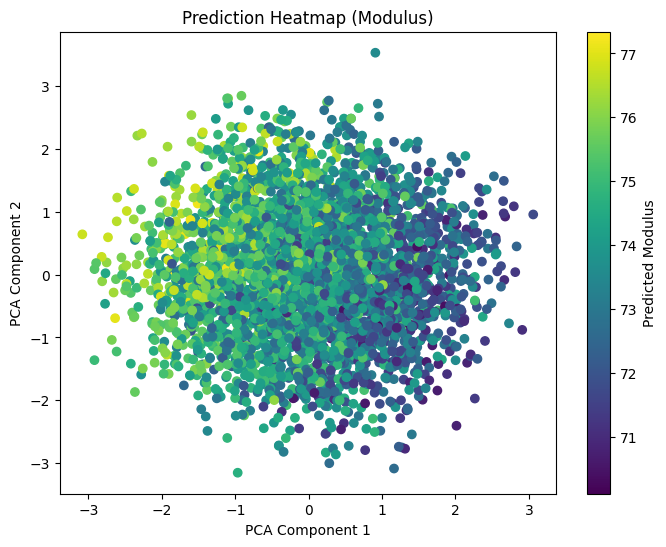

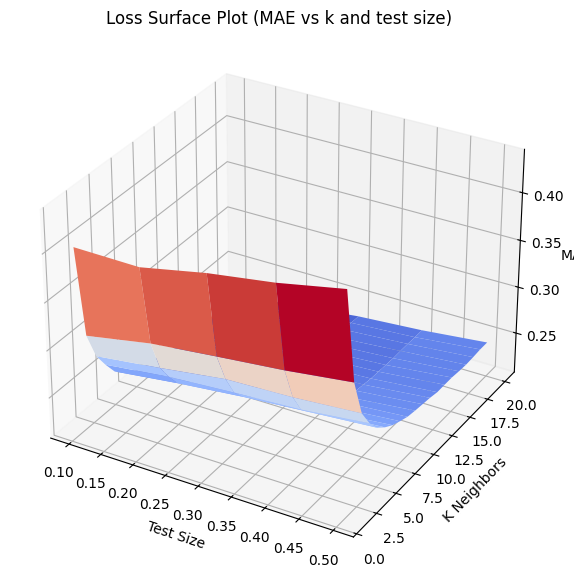

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Training & Validation Loss Curve (Simulated using K value tuning)
mae_train = []
mae_val = []
k_values = range(1, 21)

for k in k_values:
    knn_temp = KNeighborsRegressor(n_neighbors=k)
    knn_temp.fit(X_train, y_modulus_train)
    mae_train.append(mean_absolute_error(y_modulus_train, knn_temp.predict(X_train)))
    mae_val.append(mean_absolute_error(y_modulus_test, knn_temp.predict(X_test)))

plt.figure(figsize=(8, 5))
plt.plot(k_values, mae_train, label="Training MAE", marker='o')
plt.plot(k_values, mae_val, label="Validation MAE", marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Absolute Error")
plt.title("Training vs Validation Loss Curve (Tensile Modulus)")
plt.legend()
plt.grid(True)
plt.show()

# 2. Prediction vs Actual Scatter Plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_modulus_test, y=y_modulus_pred, alpha=0.8)
plt.plot([y_modulus_test.min(), y_modulus_test.max()],
         [y_modulus_test.min(), y_modulus_test.max()], 'r--')
plt.xlabel("Actual Tensile Modulus")
plt.ylabel("Predicted")
plt.title("Prediction vs Actual (Modulus)")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_strength_test, y=y_strength_pred, alpha=0.8)
plt.plot([y_strength_test.min(), y_strength_test.max()],
         [y_strength_test.min(), y_strength_test.max()], 'r--')
plt.xlabel("Actual Tensile Strength")
plt.ylabel("Predicted")
plt.title("Prediction vs Actual (Strength)")

plt.tight_layout()
plt.show()

# 3. Feature Importance (Using permutation importance)
from sklearn.inspection import permutation_importance

result = permutation_importance(knn_modulus, X_test, y_modulus_test, n_repeats=10, random_state=42, n_jobs=-1)
importances = result.importances_mean
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.xlabel("Mean Importance")
plt.title("Feature Importance (Tensile Modulus)")
plt.show()

# 4. Prediction Heatmap (Only if we use 2D projection)
# We use PCA to reduce X to 2D for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_test)

plt.figure(figsize=(8, 6))
sc = plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y_modulus_pred, cmap='viridis')
plt.colorbar(sc, label="Predicted Modulus")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Prediction Heatmap (Modulus)")
plt.show()

# 5. Loss Surface Plot (Simulated over k and test size)
from matplotlib import cm
test_sizes = np.linspace(0.1, 0.5, 5)
k_vals = range(1, 21)
loss_surface = np.zeros((len(k_vals), len(test_sizes)))

for i, k in enumerate(k_vals):
    for j, test_size in enumerate(test_sizes):
        X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
            X_scaled, y_modulus, test_size=test_size, random_state=42)
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_train_t, y_train_t)
        pred = model.predict(X_test_t)
        loss_surface[i, j] = mean_absolute_error(y_test_t, pred)

X_grid, Y_grid = np.meshgrid(test_sizes, k_vals)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_grid, Y_grid, loss_surface, cmap=cm.coolwarm)
ax.set_xlabel("Test Size")
ax.set_ylabel("K Neighbors")
ax.set_zlabel("MAE")
ax.set_title("Loss Surface Plot (MAE vs k and test size)")
plt.show()

SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# Define the parameter grid (reduced for efficiency)
param_grid = {
    'C': [10, 100],           # Removed very small/large values
    'epsilon': [0.1, 0.5],    # Common good ranges
    'gamma': ['scale']        # 'auto' removed to simplify
}

# Storage for results
svr_models = {}
svr_preds = {}
svr_metrics = {}

# Train one SVR per output
for i, target in enumerate(y.columns):
    print(f"\nTraining SVR for: {target}")

    svr = SVR()
    grid = GridSearchCV(
        estimator=svr,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=3,                  # Reduced CV folds (from 5 to 3 for speed)
        n_jobs=-1,             # Use all available cores
        verbose=0
    )

    # Fit and predict
    grid.fit(X_train_scaled, y_train.iloc[:, i])
    best_model = grid.best_estimator_
    preds = best_model.predict(X_test_scaled)

    # Store
    svr_models[target] = best_model
    svr_preds[target] = preds
    svr_metrics[target] = {
        "MAE": mean_absolute_error(y_test.iloc[:, i], preds),
        "R2": r2_score(y_test.iloc[:, i], preds),
        "Best Params": grid.best_params_
    }

# Display metrics
for target in y.columns:
    print(f"\n{target} - MAE: {svr_metrics[target]['MAE']:.4f}, "
          f"R²: {svr_metrics[target]['R2']:.4f}, "
          f"Best Params: {svr_metrics[target]['Best Params']}")


Training SVR for: Tensile modulus

Training SVR for: Tensile strength

Tensile modulus - MAE: 0.0469, R²: 0.9985, Best Params: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale'}

Tensile strength - MAE: 0.1176, R²: 1.0000, Best Params: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

param_grid = {
    'C': [1, 10, 100],
    'epsilon': [0.1, 0.5, 1],
    'gamma': ['scale', 'auto']
}

svr_models = {}
svr_preds = {}
svr_metrics = {}

for i, target in enumerate(y.columns):
    svr = SVR()
    grid = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error')
    grid.fit(X_train_scaled, y_train.iloc[:, i])

    best_model = grid.best_estimator_
    preds = best_model.predict(X_test_scaled)

    svr_models[target] = best_model
    svr_preds[target] = preds
    svr_metrics[target] = {
        "MAE": mean_absolute_error(y_test.iloc[:, i], preds),
        "R2": r2_score(y_test.iloc[:, i], preds)
    }

print(svr_metrics)


{'Tensile modulus': {'MAE': 0.04695130490340674, 'R2': 0.9985147452005285}, 'Tensile strength': {'MAE': 0.11755863525075395, 'R2': 0.9999611251694557}}


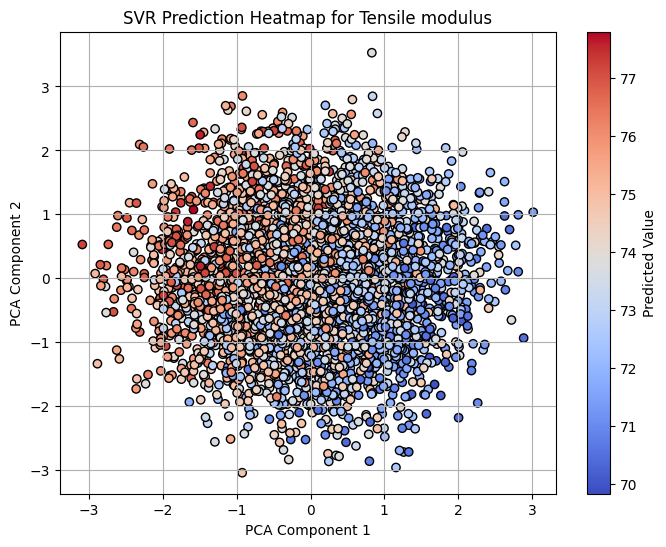

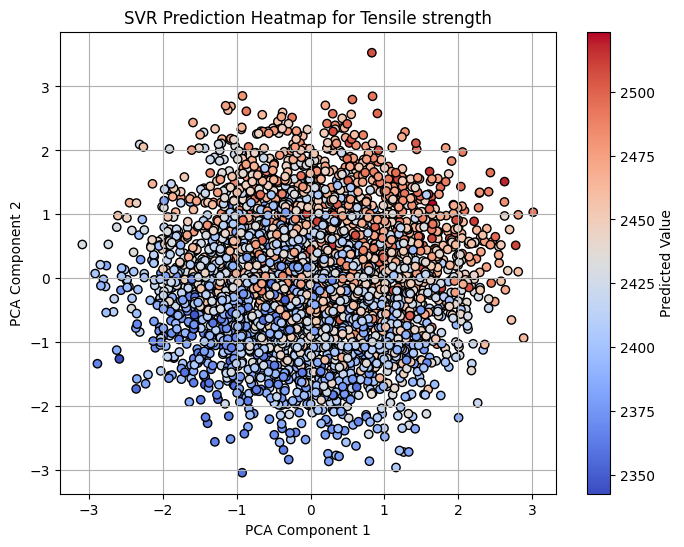

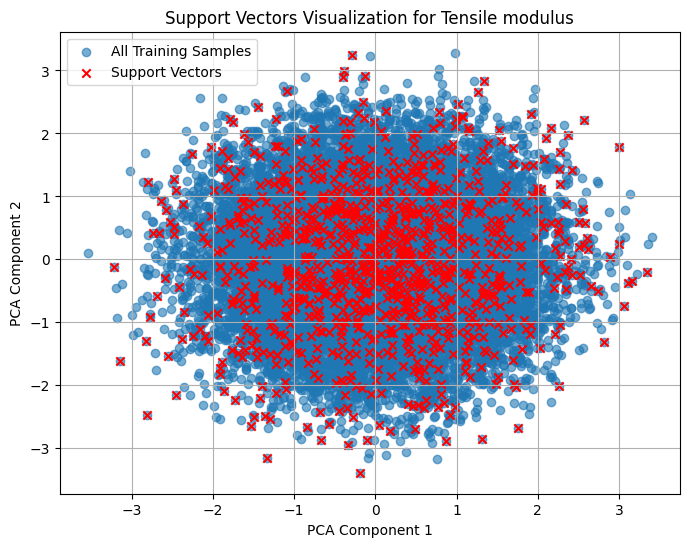

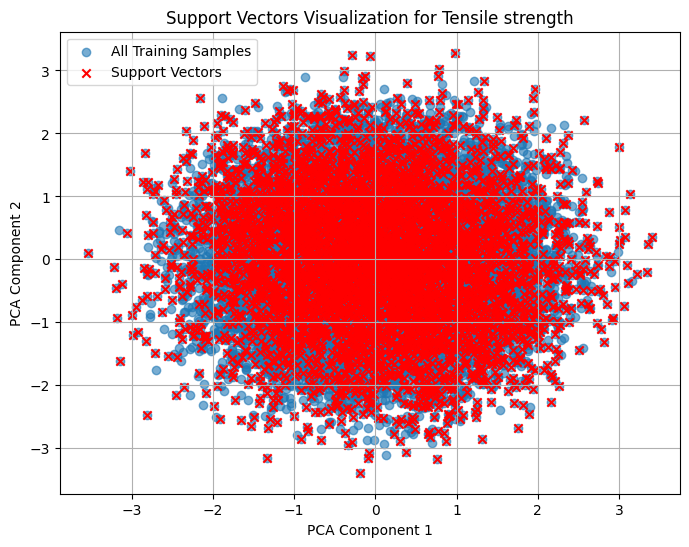

/tmp/ipython-input-16-825372543.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=maes, y=labels, palette="viridis")


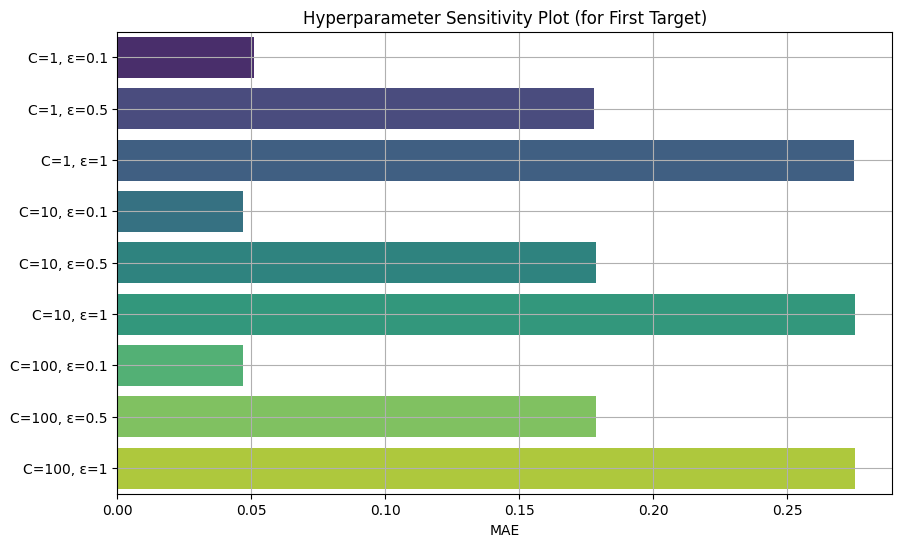

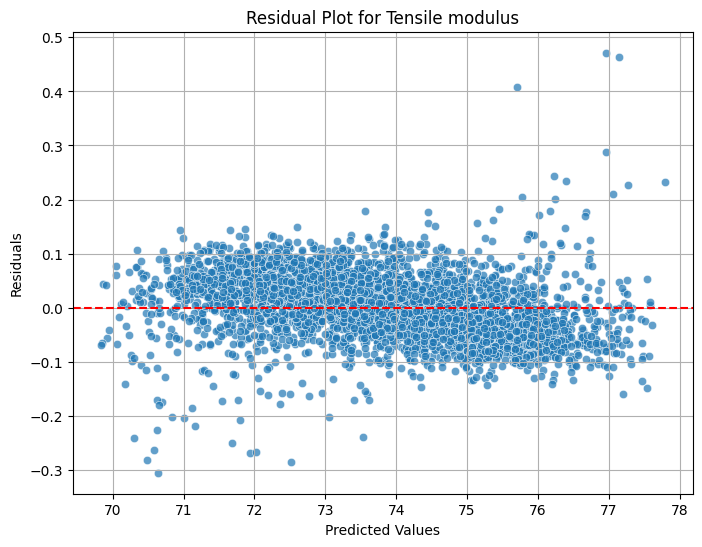

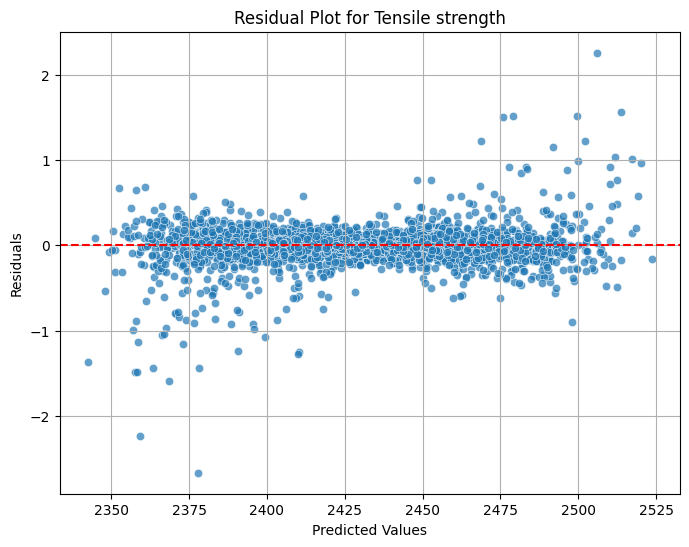

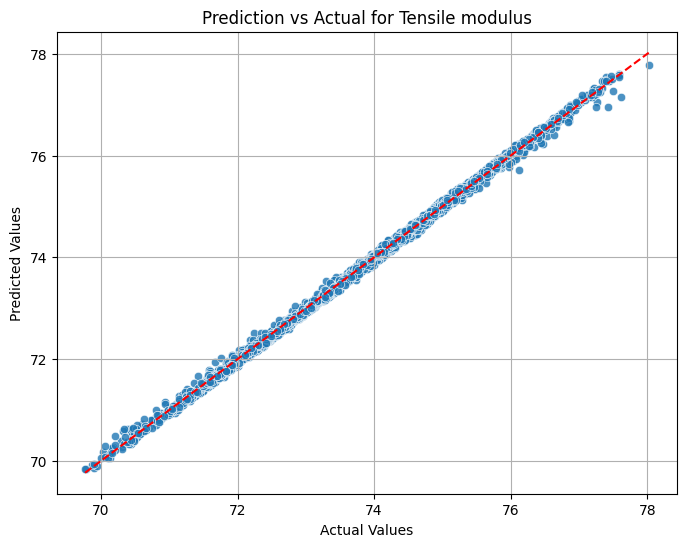

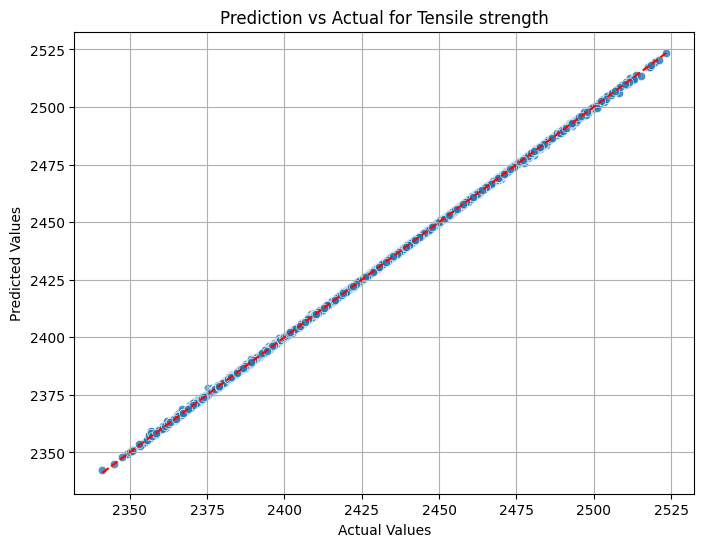

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

# 1. SVR Prediction Heatmaps (Using PCA for 2D visualization)
for target in y.columns:
    preds = svr_preds[target]

    # Reduce X_test to 2D using PCA
    pca = PCA(n_components=2)
    X_2D = pca.fit_transform(X_test_scaled)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2D[:, 0], X_2D[:, 1], c=preds, cmap='coolwarm', edgecolor='k')
    plt.colorbar(scatter, label="Predicted Value")
    plt.title(f"SVR Prediction Heatmap for {target}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

# 2. Support Vector Visualization (Only possible if model uses linear kernel)
from sklearn.decomposition import PCA

for target in y.columns:
    model = svr_models[target]
    if hasattr(model, "support_"):
        support_vectors = model.support_

        # Apply PCA on the training set
        X_train_2D = PCA(n_components=2).fit_transform(X_train_scaled)

        plt.figure(figsize=(8, 6))
        plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], label='All Training Samples', alpha=0.6)
        plt.scatter(X_train_2D[support_vectors, 0], X_train_2D[support_vectors, 1],
                    color='red', label='Support Vectors', marker='x')
        plt.title(f"Support Vectors Visualization for {target}")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.legend()
        plt.grid(True)
        plt.show()

# 3. Hyperparameter Sensitivity Plot (C vs MAE for example)
C_values = [1, 10, 100]
epsilon_values = [0.1, 0.5, 1]
sensitivity = {}

for C in C_values:
    for epsilon in epsilon_values:
        model = SVR(C=C, epsilon=epsilon, gamma='scale')
        model.fit(X_train_scaled, y_train.iloc[:, 0])  # Assume first target
        preds = model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test.iloc[:, 0], preds)
        sensitivity[(C, epsilon)] = mae

# Plotting sensitivity
C_eps = list(sensitivity.keys())
maes = list(sensitivity.values())
labels = [f"C={c}, ε={e}" for c, e in C_eps]

plt.figure(figsize=(10, 6))
sns.barplot(x=maes, y=labels, palette="viridis")
plt.xlabel("MAE")
plt.title("Hyperparameter Sensitivity Plot (for First Target)")
plt.grid(True)
plt.show()

# 4. Residual Plot
for target in y.columns:
    preds = svr_preds[target]
    residuals = y_test[target] - preds

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=preds, y=residuals, alpha=0.7)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {target}")
    plt.grid(True)
    plt.show()

# 5. Prediction vs Actual Scatter Plot
for target in y.columns:
    preds = svr_preds[target]
    actual = y_test[target]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=actual, y=preds, alpha=0.8)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Prediction vs Actual for {target}")
    plt.grid(True)
    plt.show()



Ensemble Learning

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

# Prepare the predictions
# KNN
knn_preds = {
    "Tensile modulus": y_modulus_pred,
    "Tensile strength": y_strength_pred
}

# SVR: already in svr_preds dict
# XGBoost: already in xgb_preds dict

# Averaging predictions from 3 models
ensemble_preds = {}
ensemble_metrics = {}

for target in ['Tensile modulus', 'Tensile strength']:
    # Stack predictions
    preds_xgb = np.array(xgb_preds[target])
    preds_knn = np.array(knn_preds[target])
    preds_svr = np.array(svr_preds[target])

    # Simple average
    avg_preds = (preds_xgb + preds_knn + preds_svr) / 3.0

    # Save predictions
    ensemble_preds[target] = avg_preds

    # Choose correct test target
    if target == "Tensile modulus":
        y_true = y_modulus_test
    else:
        y_true = y_strength_test

    # Evaluate
    ensemble_metrics[target] = {
        "MAE": mean_absolute_error(y_true, avg_preds),
        "R2": r2_score(y_true, avg_preds)
    }

# Display Results
for target in ensemble_metrics:
    print(f"\n{target} - Ensemble Performance")
    print(f"MAE: {ensemble_metrics[target]['MAE']:.3f}")
    print(f"R² : {ensemble_metrics[target]['R2']:.3f}")


Tensile modulus - Ensemble Performance
MAE: 0.094
R² : 0.994

Tensile strength - Ensemble Performance
MAE: 1.971
R² : 0.994


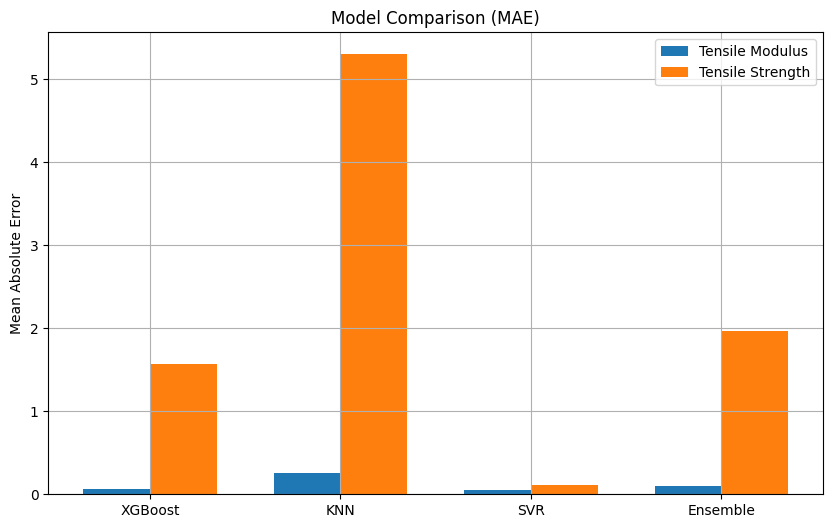

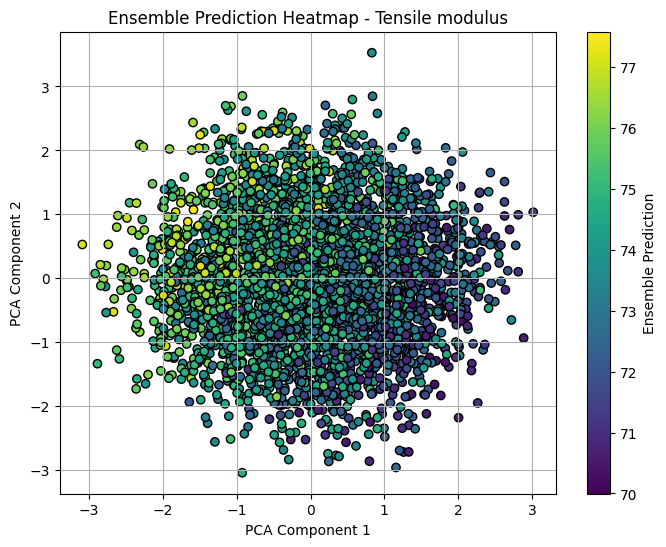

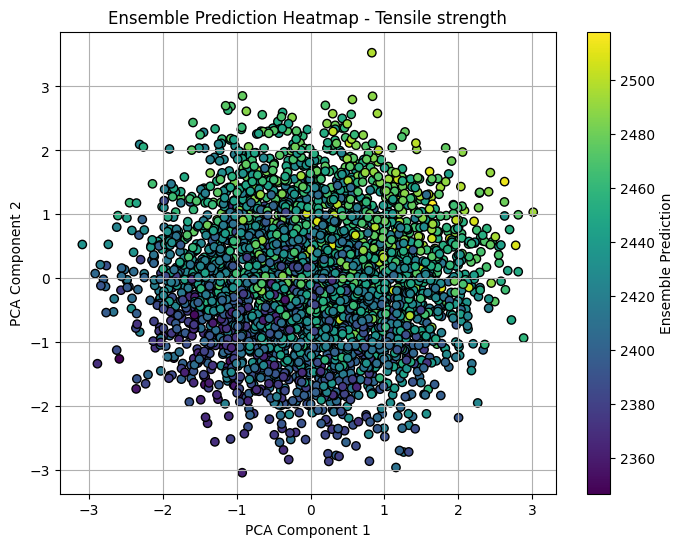

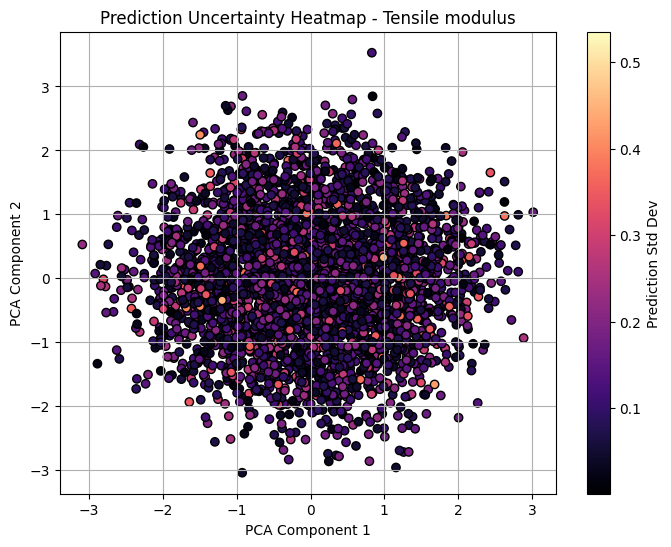

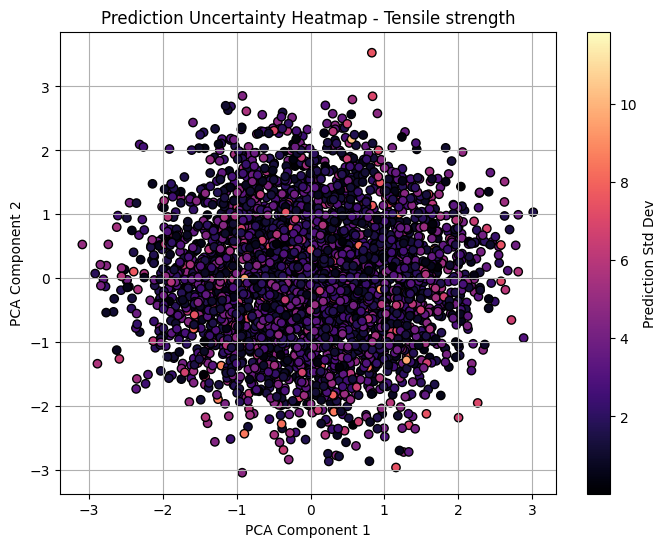

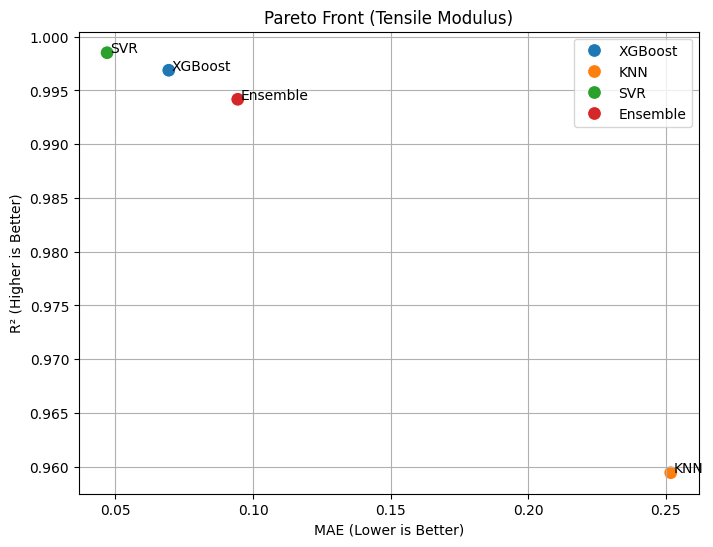

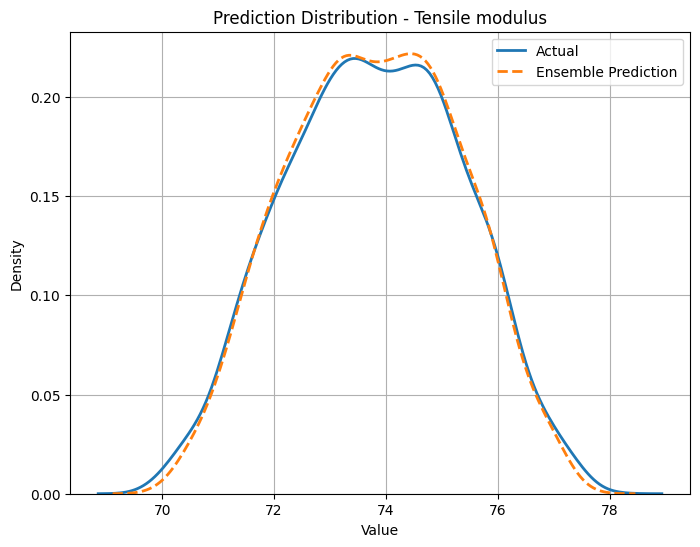

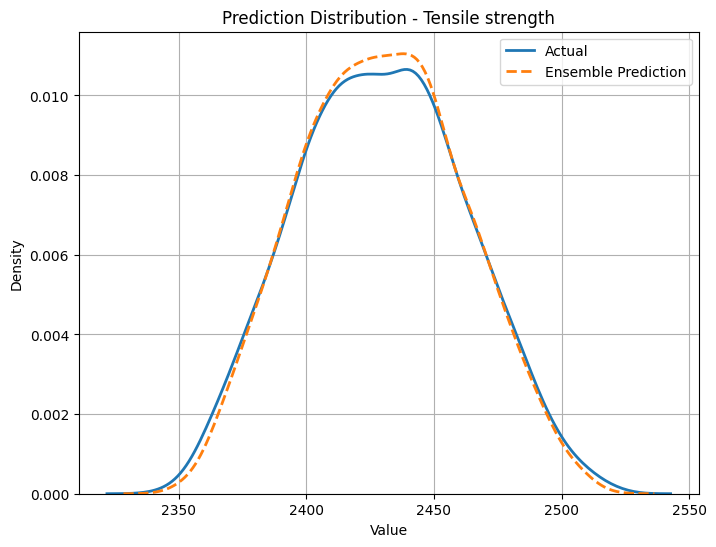

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# -------------------------------------
# 1. Model Comparison Bar Plot (MAE & R²)
# -------------------------------------
mae_scores = {
    'XGBoost': [mean_absolute_error(y_modulus_test, xgb_preds['Tensile modulus']),
                mean_absolute_error(y_strength_test, xgb_preds['Tensile strength'])],
    'KNN': [mean_absolute_error(y_modulus_test, knn_preds['Tensile modulus']),
            mean_absolute_error(y_strength_test, knn_preds['Tensile strength'])],
    'SVR': [mean_absolute_error(y_modulus_test, svr_preds['Tensile modulus']),
            mean_absolute_error(y_strength_test, svr_preds['Tensile strength'])],
    'Ensemble': [ensemble_metrics['Tensile modulus']['MAE'],
                 ensemble_metrics['Tensile strength']['MAE']]
}

models = list(mae_scores.keys())
modulus_mae = [v[0] for v in mae_scores.values()]
strength_mae = [v[1] for v in mae_scores.values()]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, modulus_mae, width, label='Tensile Modulus')
plt.bar(x + width/2, strength_mae, width, label='Tensile Strength')
plt.xticks(x, models)
plt.ylabel('Mean Absolute Error')
plt.title('Model Comparison (MAE)')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------
# 2. Ensemble Prediction Heatmaps (PCA-reduced)
# -------------------------------------
for target in ['Tensile modulus', 'Tensile strength']:
    pca = PCA(n_components=2)
    X_test_2D = pca.fit_transform(X_test_scaled)

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=ensemble_preds[target], cmap='viridis', edgecolor='k')
    plt.colorbar(sc, label="Ensemble Prediction")
    plt.title(f"Ensemble Prediction Heatmap - {target}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

# -------------------------------------
# 3. Prediction Uncertainty Heatmap (Standard Deviation among models)
# -------------------------------------
for target in ['Tensile modulus', 'Tensile strength']:
    pca = PCA(n_components=2)
    X_test_2D = pca.fit_transform(X_test_scaled)

    # Uncertainty = Std deviation across models
    all_preds = np.vstack([
        xgb_preds[target],
        knn_preds[target],
        svr_preds[target]
    ])
    std_dev = np.std(all_preds, axis=0)

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=std_dev, cmap='magma', edgecolor='k')
    plt.colorbar(sc, label="Prediction Std Dev")
    plt.title(f"Prediction Uncertainty Heatmap - {target}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

# -------------------------------------
# 4. Pareto Front with Ensemble (MAE vs R²)
# -------------------------------------
mae_vals = [v[0] for v in mae_scores.values()]
r2_vals = [
    r2_score(y_modulus_test, xgb_preds['Tensile modulus']),
    r2_score(y_modulus_test, knn_preds['Tensile modulus']),
    r2_score(y_modulus_test, svr_preds['Tensile modulus']),
    ensemble_metrics['Tensile modulus']['R2']
]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=mae_vals, y=r2_vals, hue=models, s=100)
for i, model in enumerate(models):
    plt.text(mae_vals[i]+0.001, r2_vals[i], model)

plt.xlabel("MAE (Lower is Better)")
plt.ylabel("R² (Higher is Better)")
plt.title("Pareto Front (Tensile Modulus)")
plt.grid(True)
plt.show()

# -------------------------------------
# 5. Prediction Distribution Plot (Actual vs Ensemble)
# -------------------------------------
for target, y_true in zip(['Tensile modulus', 'Tensile strength'], [y_modulus_test, y_strength_test]):
    plt.figure(figsize=(8, 6))
    sns.kdeplot(y_true, label='Actual', linewidth=2)
    sns.kdeplot(ensemble_preds[target], label='Ensemble Prediction', linestyle='--', linewidth=2)
    plt.title(f"Prediction Distribution - {target}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()


Hybrid Model

In [ ]:
pip install pyswarm


  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=66c3326e50b977c601b6a66344888847bbbd41244e657007c89a7e6fa8f58734
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
Successfully built pyswarm


In [ ]:
from pyswarm import pso
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# --- Stack base model train predictions ---
xgb_train_preds = np.column_stack([
    xgb_models['Tensile modulus'].predict(X_train_scaled),
    xgb_models['Tensile strength'].predict(X_train_scaled)
])

svr_train_preds = np.column_stack([
    svr_models['Tensile modulus'].predict(X_train_scaled),
    svr_models['Tensile strength'].predict(X_train_scaled)
])

# Combine XGB + SVR for stacking
stacked_train = np.hstack([xgb_train_preds, svr_train_preds])

# Similarly for test set predictions
xgb_test_preds = np.column_stack([
    xgb_models['Tensile modulus'].predict(X_test_scaled),
    xgb_models['Tensile strength'].predict(X_test_scaled)
])

svr_test_preds = np.column_stack([
    svr_models['Tensile modulus'].predict(X_test_scaled),
    svr_models['Tensile strength'].predict(X_test_scaled)
])

stacked_test = np.hstack([xgb_test_preds, svr_test_preds])

# Ground truths
y_modulus_train = y_train['Tensile modulus'].values
y_strength_train = y_train['Tensile strength'].values
y_modulus_test = y_test['Tensile modulus'].values
y_strength_test = y_test['Tensile strength'].values

# --- PSO Objective functions ---
def objective_modulus(weights):
    preds = np.dot(stacked_train, weights)
    return mean_absolute_error(y_modulus_train, preds)

def objective_strength(weights):
    preds = np.dot(stacked_train, weights)
    return mean_absolute_error(y_strength_train, preds)

# Bounds for PSO
n_features = stacked_train.shape[1]
lb = [0] * n_features
ub = [1] * n_features

# Optimize weights using PSO
opt_weights_modulus, _ = pso(objective_modulus, lb, ub, swarmsize=50, maxiter=100, debug=False)
opt_weights_strength, _ = pso(objective_strength, lb, ub, swarmsize=50, maxiter=100, debug=False)

# Make predictions on test data
hybrid_modulus = np.dot(stacked_test, opt_weights_modulus)
hybrid_strength = np.dot(stacked_test, opt_weights_strength)

# Evaluate
hybrid_metrics = {
    "Tensile modulus": {
        "MAE": mean_absolute_error(y_modulus_test, hybrid_modulus),
        "R2": r2_score(y_modulus_test, hybrid_modulus)
    },
    "Tensile strength": {
        "MAE": mean_absolute_error(y_strength_test, hybrid_strength),
        "R2": r2_score(y_strength_test, hybrid_strength)
    }
}

print("Hybrid Model Metrics (PSO-based, no ANN):", hybrid_metrics)


Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 100
Hybrid Model Metrics (PSO-based, no ANN): {'Tensile modulus': {'MAE': 0.04513854344201489, 'R2': 0.9986151616181973}, 'Tensile strength': {'MAE': 2.9350844683322985, 'R2': 0.9882208489254606}}


Bar Chart: MAE and R² for Each Target

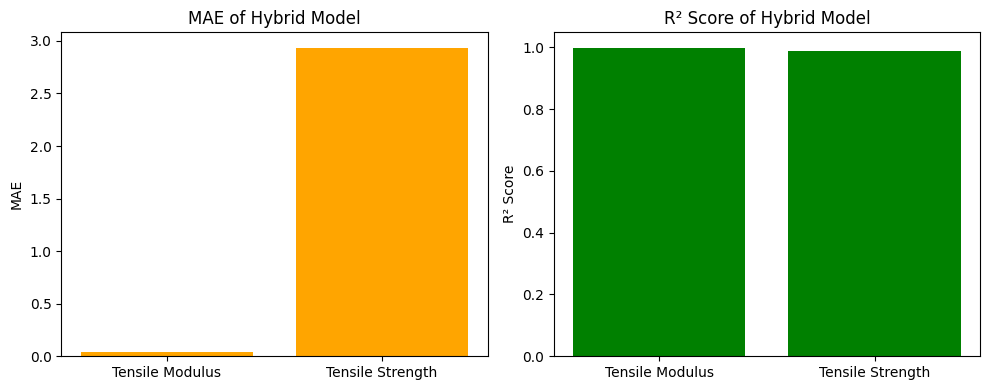

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
mae_values = [
    hybrid_metrics["Tensile modulus"]["MAE"],
    hybrid_metrics["Tensile strength"]["MAE"]
]

r2_values = [
    hybrid_metrics["Tensile modulus"]["R2"],
    hybrid_metrics["Tensile strength"]["R2"]
]

labels = ["Tensile Modulus", "Tensile Strength"]

# Plot MAE
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(labels, mae_values, color='orange')
plt.title("MAE of Hybrid Model")
plt.ylabel("MAE")

# Plot R2
plt.subplot(1, 2, 2)
plt.bar(labels, r2_values, color='green')
plt.title("R² Score of Hybrid Model")
plt.ylabel("R² Score")

plt.tight_layout()
plt.show()


Scatter Plot: Actual vs Predicted

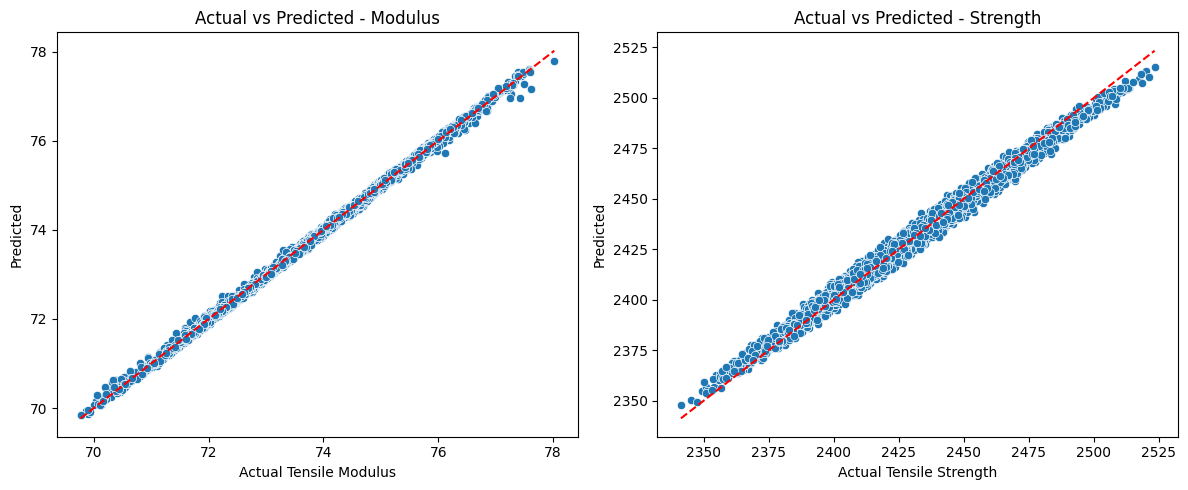

In [ ]:
import seaborn as sns

# Scatter for Tensile Modulus
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_modulus_test, y=hybrid_modulus)
plt.plot([min(y_modulus_test), max(y_modulus_test)],
         [min(y_modulus_test), max(y_modulus_test)], 'r--')
plt.xlabel("Actual Tensile Modulus")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted - Modulus")

# Scatter for Tensile Strength
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_strength_test, y=hybrid_strength)
plt.plot([min(y_strength_test), max(y_strength_test)],
         [min(y_strength_test), max(y_strength_test)], 'r--')
plt.xlabel("Actual Tensile Strength")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted - Strength")

plt.tight_layout()
plt.show()


Pie Chart: Model Weights from PSO

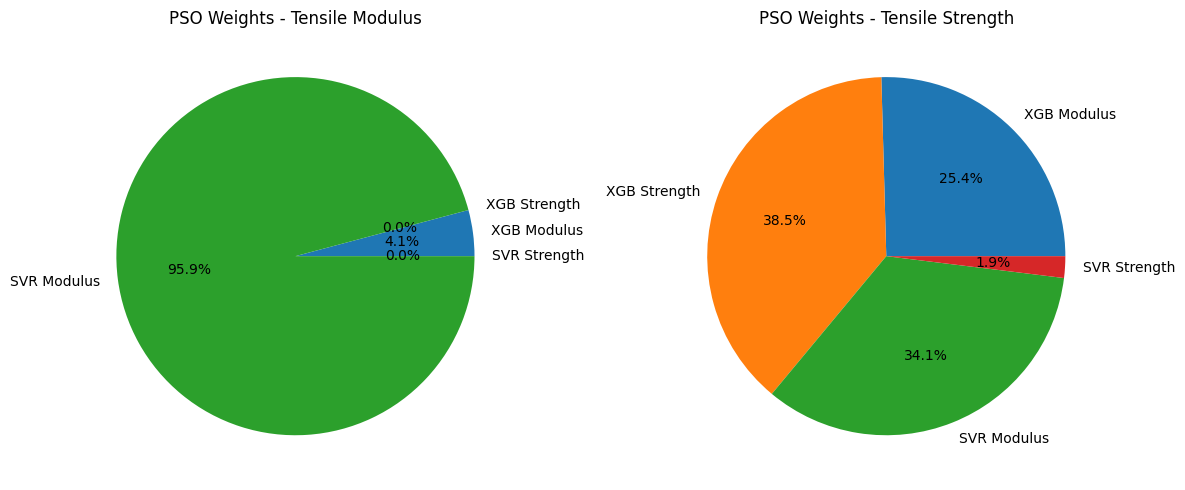

In [ ]:
# Weights learned by PSO
labels = ['XGB Modulus', 'XGB Strength', 'SVR Modulus', 'SVR Strength']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(opt_weights_modulus, labels=labels, autopct='%1.1f%%')
plt.title("PSO Weights - Tensile Modulus")

plt.subplot(1, 2, 2)
plt.pie(opt_weights_strength, labels=labels, autopct='%1.1f%%')
plt.title("PSO Weights - Tensile Strength")

plt.tight_layout()
plt.show()


Predictive System

Input Preparation

In [ ]:
import numpy as np

# Define features (order matters!)
features = [
    'matrix-to-filler ratio',
    'Density',
    'elastic modulus',
    'Amount of hardener',
    'Epoxy group content',
    'Flash point',
    'Surface density',
    'Resin consumption'
]
output_targets = ['Tensile modulus', 'Tensile strength']

def prepare_input(input_dict, features):
    """Convert input dictionary to ordered numpy array for prediction."""
    return np.array([[input_dict.get(f, 0) for f in features]])


Model Prediction Functions

In [ ]:
def predict_xgb(input_sample, xgb_models, scaler, features):
    """Predict using XGBoost (expects scaled input)."""
    input_array = prepare_input(input_sample, features)
    scaled_input = scaler.transform(input_array)
    return {target: xgb_models[target].predict(scaled_input)[0] for target in output_targets}

def predict_knn(input_sample, knn_modulus, knn_strength, scaler, features):
    """Predict using KNN (expects scaled input)."""
    input_array = prepare_input(input_sample, features)
    scaled_input = scaler.transform(input_array)
    return {
        'Tensile modulus': knn_modulus.predict(scaled_input)[0],
        'Tensile strength': knn_strength.predict(scaled_input)[0]
    }

def predict_svr(input_sample, svr_models, scaler, features):
    """Predict using SVR (expects scaled input)."""
    input_array = prepare_input(input_sample, features)
    scaled_input = scaler.transform(input_array)
    return {target: svr_models[target].predict(scaled_input)[0] for target in output_targets}

def predict_ensemble(input_sample, xgb_models, knn_modulus, knn_strength, svr_models, scaler, features):
    """Ensemble: average of XGBoost, KNN, and SVR."""
    xgb_pred = predict_xgb(input_sample, xgb_models, scaler, features)
    knn_pred = predict_knn(input_sample, knn_modulus, knn_strength, scaler, features)
    svr_pred = predict_svr(input_sample, svr_models, scaler, features)
    return {
        target: np.mean([xgb_pred[target], knn_pred[target], svr_pred[target]])
        for target in output_targets
    }


Sample Input

In [ ]:
input_sample = {
    'matrix-to-filler ratio': 2.573068,
    'Density': 2227.8214,
    'elastic modulus': 1221.1903,
    'Amount of hardener': 131.7719,
    'Epoxy group content': 18.8083,
    'Flash point': 228.0790,
    'Surface density': 76.3722,
    'Resin consumption': 375.8381
}


Prediction Display Function

In [ ]:
def print_predictions(predictions, model_name):
    print(f"\n{model_name} Predictions:")
    for target, value in predictions.items():
        print(f"{target}: {value:.3f}")


In [ ]:
# Make predictions
xgb_predictions = predict_xgb(input_sample, xgb_models, scaler, features)
print_predictions(xgb_predictions, "XGBoost")

knn_predictions = predict_knn(input_sample, knn_modulus, knn_strength, scaler, features)
print_predictions(knn_predictions, "KNN")

svr_predictions = predict_svr(input_sample, svr_models, scaler, features)
print_predictions(svr_predictions, "SVR")

ensemble_predictions = predict_ensemble(
    input_sample, xgb_models, knn_modulus, knn_strength, svr_models, scaler, features
)
print_predictions(ensemble_predictions, "Ensemble")


XGBoost Predictions:
Tensile modulus: 73.032
Tensile strength: 2487.406

KNN Predictions:
Tensile modulus: 72.870
Tensile strength: 2482.751

SVR Predictions:
Tensile modulus: 72.981
Tensile strength: 2487.649

Ensemble Predictions:
Tensile modulus: 72.961
Tensile strength: 2485.935


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

PSO Prediction

In [ ]:
Assumptions

In [ ]:
features = [
    'matrix-to-filler ratio',
    'Density',
    'elastic modulus',
    'Amount of hardener',
    'Epoxy group content',
    'Flash point',
    'Surface density',
    'Resin consumption'
]


Prepare Input Function

In [ ]:
import numpy as np

def prepare_input(input_dict, features):
    """Convert input dictionary to numpy array in correct feature order."""
    return np.array([[input_dict.get(f, 0) for f in features]])


Hybrid Prediction Function

In [ ]:
def predict_hybrid(input_sample, xgb_models, svr_models, scaler, features,
                   opt_weights_modulus, opt_weights_strength):
    """
    Predict tensile modulus and strength using PSO-weighted hybrid of XGB and SVR.
    """
    # Prepare and scale input
    input_array = prepare_input(input_sample, features)
    input_scaled = scaler.transform(input_array)

    # Get base model predictions
    xgb_preds = np.array([
        xgb_models['Tensile modulus'].predict(input_scaled)[0],
        xgb_models['Tensile strength'].predict(input_scaled)[0]
    ])

    svr_preds = np.array([
        svr_models['Tensile modulus'].predict(input_scaled)[0],
        svr_models['Tensile strength'].predict(input_scaled)[0]
    ])

    # Stack predictions as in training (order must match)
    stacked_preds = np.hstack([xgb_preds, svr_preds])  # shape (4,)

    # Calculate weighted predictions using PSO weights
    pred_modulus = np.dot(stacked_preds, opt_weights_modulus)
    pred_strength = np.dot(stacked_preds, opt_weights_strength)

    return {
        'Tensile modulus': pred_modulus,
        'Tensile strength': pred_strength
    }


In [ ]:
input_sample = {
    'matrix-to-filler ratio': 2.573068,
    'Density': 2227.8214,
    'elastic modulus': 1221.1903,
    'Amount of hardener': 131.7719,
    'Epoxy group content': 18.8083,
    'Flash point': 228.0790,
    'Surface density': 76.3722,
    'Resin consumption': 375.8381
}

hybrid_preds = predict_hybrid(
    input_sample, xgb_models, svr_models, scaler, features,
    opt_weights_modulus, opt_weights_strength
)

print("Hybrid Model Predictions (PSO weighted):")
for k, v in hybrid_preds.items():
    print(f"{k}: {v:.4f}")


Hybrid Model Predictions (PSO weighted):
Tensile modulus: 72.9842
Tensile strength: 2483.8560


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predict test data results

In [ ]:
import pandas as pd

In [ ]:
# Load test data
test_df = pd.read_csv('test_data.csv')

In [ ]:
# Define feature columns
features = [
    'matrix-to-filler ratio',
    'Density',
    'elastic modulus',
    'Amount of hardener',
    'Epoxy group content',
    'Flash point',
    'Surface density',
    'Resin consumption'
]
output_targets = ['Tensile modulus', 'Tensile strength']

X_test = test_df[features]
y_test = test_df[output_targets]

Scale Test Data

In [ ]:
# Use the scaler fitted on your training data
X_test_scaled = scaler.transform(X_test)


Predict with Each Model

In [ ]:
import numpy as np

# XGBoost
xgb_modulus_pred = xgb_models['Tensile modulus'].predict(X_test_scaled)
xgb_strength_pred = xgb_models['Tensile strength'].predict(X_test_scaled)

# KNN
knn_modulus_pred = knn_modulus.predict(X_test_scaled)
knn_strength_pred = knn_strength.predict(X_test_scaled)

# SVR
svr_modulus_pred = svr_models['Tensile modulus'].predict(X_test_scaled)
svr_strength_pred = svr_models['Tensile strength'].predict(X_test_scaled)

# Ensemble (average)
ensemble_modulus_pred = (xgb_modulus_pred + knn_modulus_pred + svr_modulus_pred) / 3
ensemble_strength_pred = (xgb_strength_pred + knn_strength_pred + svr_strength_pred) / 3

# PSO Hybrid
# Stack predictions as in your PSO code
xgb_test_preds = np.column_stack([xgb_modulus_pred, xgb_strength_pred])
svr_test_preds = np.column_stack([svr_modulus_pred, svr_strength_pred])
stacked_test = np.hstack([xgb_test_preds, svr_test_preds])

hybrid_modulus_pred = np.dot(stacked_test, opt_weights_modulus)
hybrid_strength_pred = np.dot(stacked_test, opt_weights_strength)


Plot Results

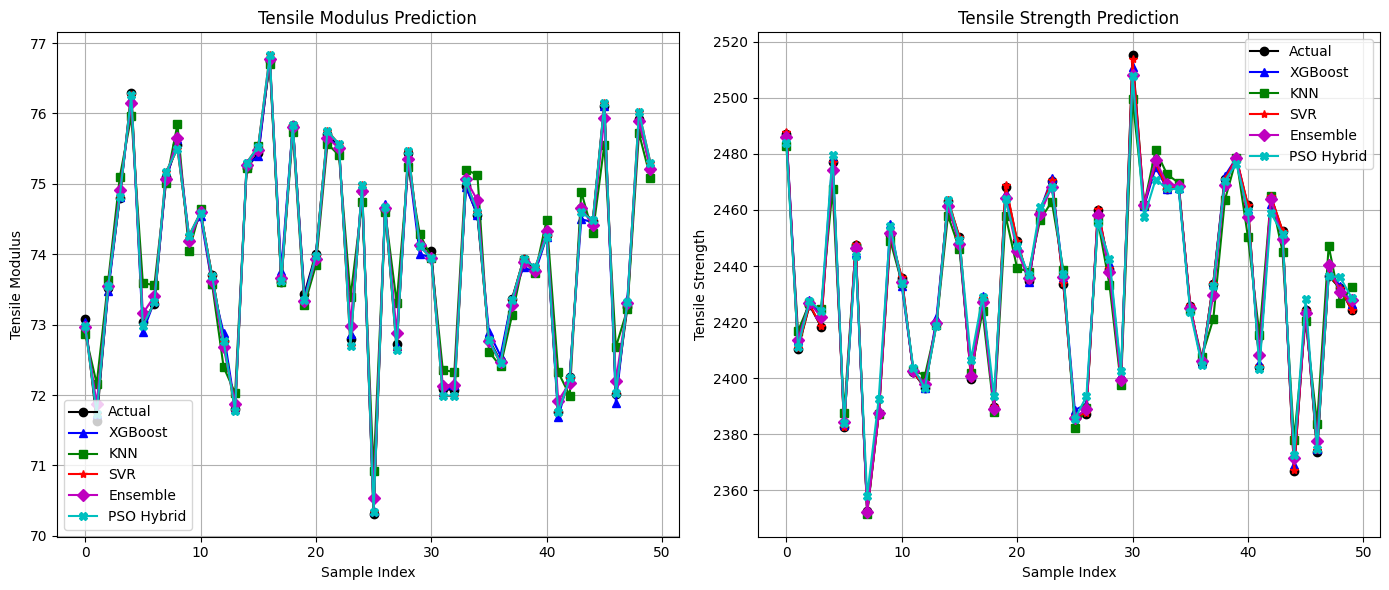

In [ ]:
import matplotlib.pyplot as plt

indices = range(len(X_test))

# Tensile modulus
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(indices, y_test['Tensile modulus'], 'ko-', label='Actual')
plt.plot(indices, xgb_modulus_pred, 'b^-', label='XGBoost')
plt.plot(indices, knn_modulus_pred, 'gs-', label='KNN')
plt.plot(indices, svr_modulus_pred, 'r*-', label='SVR')
plt.plot(indices, ensemble_modulus_pred, 'mD-', label='Ensemble')
plt.plot(indices, hybrid_modulus_pred, 'cX-', label='PSO Hybrid')
plt.title('Tensile Modulus Prediction')
plt.xlabel('Sample Index')
plt.ylabel('Tensile Modulus')
plt.legend()
plt.grid(True)

# Tensile strength
plt.subplot(1,2,2)
plt.plot(indices, y_test['Tensile strength'], 'ko-', label='Actual')
plt.plot(indices, xgb_strength_pred, 'b^-', label='XGBoost')
plt.plot(indices, knn_strength_pred, 'gs-', label='KNN')
plt.plot(indices, svr_strength_pred, 'r*-', label='SVR')
plt.plot(indices, ensemble_strength_pred, 'mD-', label='Ensemble')
plt.plot(indices, hybrid_strength_pred, 'cX-', label='PSO Hybrid')
plt.title('Tensile Strength Prediction')
plt.xlabel('Sample Index')
plt.ylabel('Tensile Strength')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

def print_metrics(y_true, y_pred, name):
    print(f"{name} - MAE: {mean_absolute_error(y_true, y_pred):.3f}, R²: {r2_score(y_true, y_pred):.3f}")

print_metrics(y_test['Tensile modulus'], xgb_modulus_pred, "XGBoost Modulus")
print_metrics(y_test['Tensile modulus'], knn_modulus_pred, "KNN Modulus")
print_metrics(y_test['Tensile modulus'], svr_modulus_pred, "SVR Modulus")
print_metrics(y_test['Tensile modulus'], ensemble_modulus_pred, "Ensemble Modulus")
print_metrics(y_test['Tensile modulus'], hybrid_modulus_pred, "PSO Hybrid Modulus")

print_metrics(y_test['Tensile strength'], xgb_strength_pred, "XGBoost Strength")
print_metrics(y_test['Tensile strength'], knn_strength_pred, "KNN Strength")
print_metrics(y_test['Tensile strength'], svr_strength_pred, "SVR Strength")
print_metrics(y_test['Tensile strength'], ensemble_strength_pred, "Ensemble Strength")
print_metrics(y_test['Tensile strength'], hybrid_strength_pred, "PSO Hybrid Strength")


XGBoost Modulus - MAE: 0.060, R²: 0.997
KNN Modulus - MAE: 0.236, R²: 0.955
SVR Modulus - MAE: 0.048, R²: 0.998
Ensemble Modulus - MAE: 0.079, R²: 0.995
PSO Hybrid Modulus - MAE: 0.046, R²: 0.998
XGBoost Strength - MAE: 1.513, R²: 0.997
KNN Strength - MAE: 4.925, R²: 0.968
SVR Strength - MAE: 0.275, R²: 1.000
Ensemble Strength - MAE: 1.905, R²: 0.995
PSO Hybrid Strength - MAE: 2.749, R²: 0.990
